# Eigenfaces (PCA for recognition)

In [ ]:
from glob import glob
import cv2
from matplotlib import pyplot as plt
import numpy as np

400 112 92


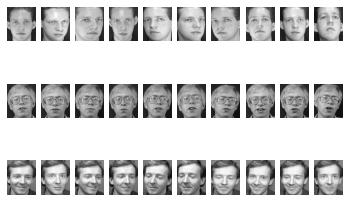

Working data shape: (10304, 400)


In [ ]:
# 1. Loading and analysing data
list_images = sorted(glob('*.bmp'))
M = len(list_images)
tmp = cv2.imread(list_images[0], cv2.IMREAD_GRAYSCALE)
r,c = tmp.shape
print(M, r, c)

# Display first 30 images
fig, axs = plt.subplots(3,10)
for i in range(30):
    axs[i//10,i%10].imshow(cv2.imread(list_images[i], cv2.IMREAD_GRAYSCALE),cmap='gray')
    axs[i//10,i%10].axis('off')
plt.show()


data = np.zeros((r*c, M))
for i in range(M):
  data[:, i] = np.reshape(cv2.imread(list_images[i], cv2.IMREAD_GRAYSCALE), r*c)
print("Working data shape:", data.shape)

In [ ]:
# 2. Extract the image of a face for each individual as a test item (tot 40 faces) and create dataset partitions the training data
test_inds = np.array([x*10 + 9 for x in range(M//10)])
test_flag = np.zeros((M,))

test_flag[test_inds] = 1
test_data = data[:, test_inds]
train_data = data[:, test_flag==0]

# Assign labels
test_labels = np.arange(1,41)
train_labels = np.repeat(np.arange(1,41),9,axis=0)

[ 1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3
  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5  5  6  6  6
  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8
  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11
 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13 13 13 13 13 13 13 14 14 14
 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15 16 16 16 16 16 16 16 16 16
 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18 18 18 18 19 19 19 19 19 19
 19 19 19 20 20 20 20 20 20 20 20 20 21 21 21 21 21 21 21 21 21 22 22 22
 22 22 22 22 22 22 23 23 23 23 23 23 23 23 23 24 24 24 24 24 24 24 24 24
 25 25 25 25 25 25 25 25 25 26 26 26 26 26 26 26 26 26 27 27 27 27 27 27
 27 27 27 28 28 28 28 28 28 28 28 28 29 29 29 29 29 29 29 29 29 30 30 30
 30 30 30 30 30 30 31 31 31 31 31 31 31 31 31 32 32 32 32 32 32 32 32 32
 33 33 33 33 33 33 33 33 33 34 34 34 34 34 34 34 34 34 35 35 35 35 35 35
 35 35 35 36 36 36 36 36 36 36 36 36 37 37 37 37 37

In [ ]:
#3 Apply PCA and project the train images into a space of dimension N

# 3a. calculate the mean and centre the data
m = np.mean(train_data, axis=1)
Xc = train_data - m[:,np.newaxis]

# 3b. calculate the covariance matrix 
C = np.cov(Xc.T, rowvar=False)
# 3c. extract eigenvectors (eigenfaces) and eigenvalues of the covariance matrix
lambdas, U = np.linalg.eigh(C)

# 3d. order the eigenvalues from largest to smallest
best_eig_idxs = np.argsort(lambdas)[::-1]
best_eig = lambdas[best_eig_idxs]
best_U = U[:,best_eig_idxs]

# 3e. check the amount of variance in the data that each eigenvalue carries and set N equal to the number of eigenvectors 
# sufficient to contain at least 80% of the total variance.
d = lambdas.shape[0]
fig, axs = plt.subplots(2)
axs[0].plot(np.arange(1,d+1),best_eig)
axs[0].scatter(np.arange(1,d+1),best_eig)

y = np.cumsum(best_eig)/np.sum(best_eig)
axs[1].plot(np.arange(1,d+1),y)
axs[1].scatter(np.arange(1,d+1),y)

plt.show()

N = np.where(y >= 0.8)[0][0]

(10304, 10304)


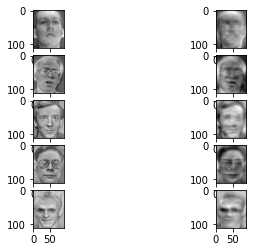

1: It's a familiar face! I'll show you!
2: It's a familiar face! I'll show you!
3: It's a familiar face! I'll show you!
4: It's a familiar face! I'll show you!
5: It's a familiar face! I'll show you!


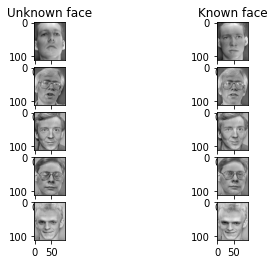

Classifier accuracy: 97.50%


In [ ]:
# 3f. project the data using the N largest eigenvectors
Tr = best_U[:,:N]
omega = Tr.T.dot(Xc)

# 4. Calculating the Theta threshold
from scipy.spatial.distance import cdist 
theta = np.max(cdist(omega.T, omega.T, 'euclidean'))

# 5. Centre my test data
x_te = test_data - m[:,np.newaxis]
omega_te = Tr.T.dot(x_te)

# 6. Calculating the set of epsilon distances
epsilon = []
for i in range(test_data.shape[1]):
  tmp_test = omega_te[:,i]
  epsilon.append(np.linalg.norm(tmp_test[:,np.newaxis] - omega, ord=2, axis=0))

epsilon = np.array(epsilon)

# 7. reconstruct the faces and make an imshow of the original against the reconstructed one in the first 5 images!
g= Tr.dot(omega_te)
fig,axs = plt.subplots(5,2)
for i in range(5):
  axs[i,0].imshow(x_te[:,i].reshape((r,c)), cmap='gray')
  axs[i,1].imshow(g[:,i].reshape((r,c)), cmap='gray')
plt.show()

# 8. Calculation xi for classification
xi = np.linalg.norm(g-x_te, ord=2, axis=0)

#9. In which of the 3 cases are we for each test face? Is the corresponding face of the same person? Check the first 5 faces
fig,axs = plt.subplots(5,2)
for i in range(5):
  if xi[i] >= theta:
    print(str(i+1) + ": It's not a face!")
  elif xi[i] < theta and any(epsilon[i,:]>theta):
    print(str(i+1) + ": It's a new face!")
  elif xi[i] < theta and np.min(epsilon[i,:]) < theta:
    print(str(i+1) + ": It's a familiar face! I'll show you!")
    matched_indx = np.argmin(epsilon[i,:])
    axs[i,0].imshow(x_te[:,i].reshape((r,c)), cmap='gray')
    axs[i,1].imshow(Xc[:,matched_indx].reshape((r,c)), cmap='gray')
    if i == 0:
      axs[i,0].set_title('Unknown face')
      axs[i,1].set_title('Known face')
plt.show()

# 10. Calculate the accuracy of the classifier and test how the result changes when N (+/- eigenvectors) is changed
# Set the prediction equal to -1 in case of classification as no face or new face, 
# equal to the train sample label with lower epsilon if a match is found

predicted = []
for i in range(test_data.shape[1]):
  if xi[i] < theta and np.min(epsilon[i,:]) < theta:
    predicted.append(train_labels[np.argmin(epsilon[i,:])])
  else:
    predicted.append(-1)

predicted = np.array(predicted)
accuracy = np.sum(predicted == test_labels)

print('Classifier accuracy: ' + "{0:.2f}".format(accuracy/len(test_labels)*100) + '%')